In [1]:
import os
os.environ['KERAS_BACKEND'] = 'torch'
from numpy import mean
from numpy import std
import numpy as np
import pandas as pd
from dateutil.relativedelta import relativedelta
#choose kernel (keras-env) when run on Macbook Pro 
import keras
from keras import layers
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import train_test_split
import torch
from datetime import datetime
import calendar
import random
import speasy as spz
from speasy import amda 
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import seaborn as sns

In [2]:
def E_mhd(df):
    '''
    [B] = nT
    [u] = km/s
    [E] = µV/m => mV/m
    '''
    dg = pd.DataFrame(index=df.index,columns=['ex','ey','ez'])
    dg['ex']=(df['by']*df['uz']-df['uy']*df['bz'])/1e3
    dg['ey']=-(df['bz']*df['ux']-df['uz']*df['bx'])/1e3 #MINUS SIGN TO FIT MEASUREMENTS IN MMS1 MAYBE THERE IS A ISSUE WITH THE MEASUREMENT TOOL IN MMS1
    dg['ez']=(df['bx']*df['uy']-df['ux']*df['by'])/1e3
    return dg

def E_hall(df):
    '''
    [B] = nT
    [j] = A/m^2
    [n] = cm^-3
    [E] = *1e-15 V/m => 1e-12 mV/m
    '''
    dg = pd.DataFrame(index=df.index,columns=['ex','ey','ez'])
    dg['ex']= ((df['jy']*df['bz']-df['by']*df['jz'])/(e*df['e_density']))/1e12
    dg['ey']= ((df['jz']*df['bx']-df['bz']*df['jx'])/(e*df['e_density']))/1e12
    dg['ez']= ((df['jx']*df['by']-df['bx']*df['jy'])/(e*df['e_density']))/1e12
    return dg

In [3]:
### Fix the random seed for producible resutls 

# Seed value
seed = 1
#random.seed(seed)
#np.random.seed(seed)
#tf.random.set_seed(seed)

# 1. Set the `PYTHONHASHSEED` environment variable at a fixed value

os.environ['PYTHONHASHSEED']=str(seed)

# 2. Set the `python` built-in pseudo-random generator at a fixed value

random.seed(seed)

# 3. Set the `numpy` pseudo-random generator at a fixed value
np.random.seed(seed)

# 4. Set the `torch` pseudo-random generator at a fixed value
torch.manual_seed(seed)

torch.use_deterministic_algorithms(mode=False)

In [4]:
e = 1.602176634e-19
m_i = 1.67262192369e-27
m_e = 9.1093837015e-31
## Global interval - all the data will be inside this range
sat = 'mms1'
t1 = datetime(2015,9,7,0,0,0)
t2 = datetime(2015,9,30,0,0,0)
store = pd.HDFStore('./data.hdf5','r')
bursts = store.keys()
store.close()
bursts = [datetime.strptime(burst, '/mms1_%Y_%m_%dT%H_%M_%S') for burst in bursts]
bursts = pd.DataFrame(bursts)
bursts = bursts.where((str(t1.date()) < bursts)&(bursts < str(t2.date()))).dropna()
df = pd.concat([pd.read_hdf('./data.hdf5',key=sat+"_"+datetime.strftime(pd.to_datetime(event[0]),format='%Y_%m_%dT%H_%M_%S')) for event in bursts.values]).dropna()
df['ux']=(m_i*df['vx_i']+m_e*df['vx_e'])/(m_i+m_e)
df['uy']=(m_i*df['vy_i']+m_e*df['vy_e'])/(m_i+m_e)
df['uz']=(m_i*df['vz_i']+m_e*df['vz_e'])/(m_i+m_e)
df = df.where(df['e_density']>1).dropna()

In [105]:
PINNS = False

if PINNS:
    df[['ex_mhd','ey_mhd','ez_mhd']] = E_mhd(df)
    df[['ex_hall','ey_hall','ez_hall']] = E_hall(df)
    ## Input / Output wanted
    input_features = ['bx', 'by', 'bz',
                'jx', 'jy', 'jz',
                'ux', 'uy', 'uz',
                'ex_mhd','ey_mhd','ez_mhd',
                'ex_hall','ey_hall','ez_hall',
                'e_density',]
    output_targets = ['ex','ey','ez']
else:
    ## Input / Output wanted
    input_features = ['bx', 'by', 'bz',
                'jx', 'jy', 'jz',
                'ux', 'uy', 'uz',
                'e_density',]
    output_targets = ['ex','ey','ez']

df = df.drop(df.columns.drop(input_features+output_targets),axis=1)
df0 = df

In [106]:
## Global interval - all the data will be inside this range
f_train, f_test, f_valid = 0.80, 0.1, 0.1
## Train interval 
id_train_beg = 0
id_train_end = int(len(df.index)*(f_train))

t_train_begin = df.index.values[0]
t_train_end = df.index.values[id_train_end]
print("Train interval: ", t_train_begin, t_train_end)

## Validation interval

id_val_beg = id_train_end+1
id_val_end = int(len(df.index)*(f_train+f_valid))
t_val_begin = df.index.values[id_val_beg]
t_val_end = df.index.values[id_val_end]
print("Validation interval: ", t_val_begin, t_val_end)

## Test interval 
id_test_beg = id_val_end + 1
id_test_end =  int(len(df.index))-1
t_test_begin = df.index.values[id_test_beg]
t_test_end = df.index.values[id_test_end]
print("Test interval: ", t_test_begin, t_test_end)


df_train, df_test = train_test_split(df,test_size = f_test+f_valid,train_size=f_train,random_state=seed,shuffle=True)
df_val, df_test = df_test.iloc[:len(df_test)//2,:], df_test.iloc[len(df_test)//2:,:]

Train interval:  2015-09-07T13:12:32.321000000 2015-09-23T08:55:43.999000000
Validation interval:  2015-09-23T08:55:44.149000000 2015-09-25T11:56:46.080000000
Test interval:  2015-09-25T11:56:46.230000000 2015-09-27T13:22:43.727000000


In [107]:
df_train.index

DatetimeIndex(['2015-09-19 07:45:09.106000', '2015-09-07 15:20:50.367000',
               '2015-09-25 09:30:10.775000', '2015-09-09 19:15:51.580000',
               '2015-09-20 15:25:02.661000', '2015-09-09 14:32:08.876000',
               '2015-09-09 15:07:02.289000', '2015-09-07 14:18:46.145000',
               '2015-09-23 08:57:47.449000', '2015-09-08 11:18:29.875000',
               ...
               '2015-09-22 12:56:36.562000', '2015-09-14 14:18:24.970000',
               '2015-09-07 15:38:58.624000', '2015-09-09 15:01:57.787000',
               '2015-09-08 11:06:04.671000', '2015-09-20 14:46:49.746000',
               '2015-09-25 13:01:07.555000', '2015-09-25 09:05:18.565000',
               '2015-09-25 13:38:21.669000', '2015-09-09 16:14:47.614000'],
              dtype='datetime64[ns]', length=431936, freq=None)

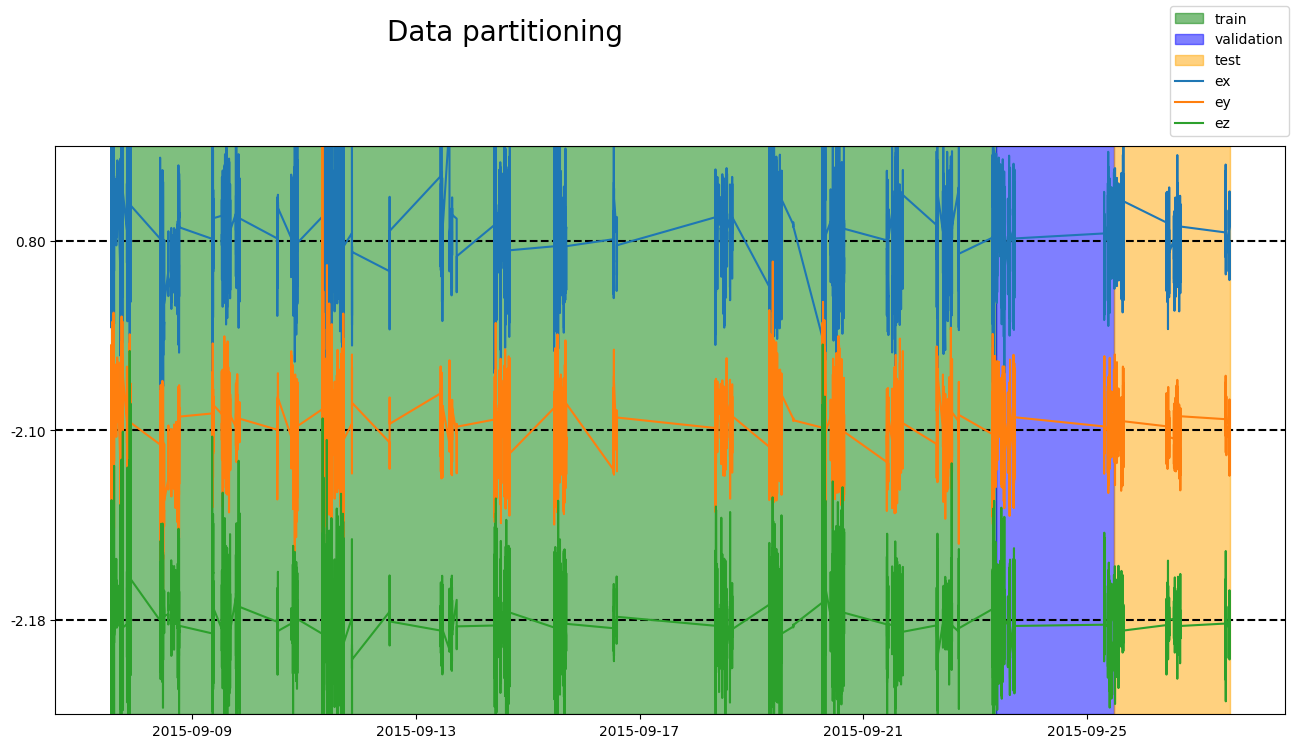

In [108]:
def f(X,mid):
    Y = mid + (X - X.mean()) / (X.max() - X.min())
    return Y
fig, ax = plt.subplots(1, 1, figsize=(12, 8))
plt.subplots_adjust(hspace=0.25)

ax.axvspan(ymin=0,ymax=1, xmin=df.index[id_train_beg],xmax=df.index[id_train_end],label='train',color='green',alpha=0.5)
ax.axvspan(ymin=0,ymax=1, xmin=df.index[id_val_beg],xmax=df.index[id_val_end],label='validation',color='blue',alpha=0.5)
ax.axvspan(ymin=0,ymax=1, xmin=df.index[id_test_beg],xmax=df.index[id_test_end],label='test',color='orange',alpha=0.5)



mids = 1*(np.linspace(0,1,4)[1:]+np.linspace(0,1,4)[:-1])/2

ax.axhline(mids[0],color='black',linestyle='--')
ax.axhline(mids[1],color='black',linestyle='--')
ax.axhline(mids[2],color='black',linestyle='--')
ax.plot(df.index.values,1*f(df['ex'],mids[-1]),label='ex')
ax.plot(df.index.values,1*f(df['ey'],mids[-2]),label='ey')
ax.plot(df.index.values,1*f(df['ez'],mids[-3]),label='ez')

ax.set_yticks(mids,[f'{df[e].mean():.2f}' for e in ['ex','ey','ez']])
ax.set_ylim(0,1)
fig.legend()

fig.subplots_adjust(top=0.82)
fig.subplots_adjust(right=1.15)
fig.suptitle("Data partitioning", fontsize=20)

plt.show()

In [109]:
df = df.drop(df.columns.drop(input_features+output_targets),axis=1) #drop useless data
df = df[input_features + output_targets] #reorder columns for input to the left and output to the right

In [110]:
## Define a scaler function
scaler = MinMaxScaler()
## Obtain scaler based on the “train” data
df_train_scaled = scaler.fit_transform(df_train)
## Apply the scaling obtained from the “train” data to “validation” and “test” data
df_val_scaled = scaler.transform(df_val)
df_test_scaled = scaler.transform(df_test)

In [111]:
## Get input 'X'
X_train = df_train_scaled[:,0:len(input_features)]
X_test = df_test_scaled[:,0:len(input_features)]
X_val = df_val_scaled[:,0:len(input_features)]
## Get output 'y'
y_train = df_train_scaled[:,len(input_features):len(input_features)+len(output_targets)]
y_test = df_test_scaled[:,len(input_features):len(input_features)+len(output_targets)]
y_val = df_val_scaled[:,len(input_features):len(input_features)+len(output_targets)]

In [112]:
def first_dnn(input_features,output_targets):
    model = keras.Sequential([
        layers.Dense(len(input_features), activation='relu'),
        layers.Dense(64, activation='relu'),
        layers.Dense(64, activation='relu'),
        layers.Dropout(0.2),
        layers.Dense(len(output_targets))
    ])
    model.compile(loss='mean_absolute_error',
                optimizer=keras.optimizers.Adam(0.001))

    return model

In [114]:
# Recreate the exact same model, including its weights and the optimizer
name = f'DNN_PINNS={PINNS}_Shuffle'
new_model = keras.models.load_model(f'../Saved_models/{name}/model.keras')

# Show the model architecture
new_model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (32, 10)               │           110 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (32, 64)               │           704 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (32, 64)               │         4,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (32, 64)               │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (32, 3)                │           195 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 15,509 (60.58 KB)

 Trainable params: 5,169 (20.19 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 10,340 (40.39 KB)

In [115]:
test_predict = new_model.predict(X_test)

1688/1688 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step


In [116]:
print('Test 1', t_test_begin, t_test_end)

score_test = new_model.evaluate(X_test, y_test, verbose=0)
print('\nLoss score = ', score_test)

mse_test = []
for i in range(y_test.shape[1]):
    mse_test.append(mean_squared_error(y_test[:,i], test_predict[:,i]))
print('\nMSE of all targets = ', mse_test)

Pcc_xyz_test = []
for i in range(y_test.shape[1]):
    Pcc_xyz_test.append(round(np.corrcoef(y_test[:,i], test_predict[:,i])[0,1],3))
print('\nPcc of all targets = ', Pcc_xyz_test)

r2_xyz_test = []
for i in range(y_test.shape[1]):
    r2_xyz_test.append(round(r2_score(y_test[:,i], test_predict[:,i]),3))
print('\nr2 of all targets = ', r2_xyz_test)


Test 1 2015-09-25T11:56:46.230000000 2015-09-27T13:22:43.727000000

Loss score =  0.010016171261668205

MSE of all targets =  [0.0002852519584446799, 0.0001682646909736227, 0.0002713748816092958]

Pcc of all targets =  [0.962, 0.969, 0.887]

r2 of all targets =  [0.923, 0.938, 0.784]


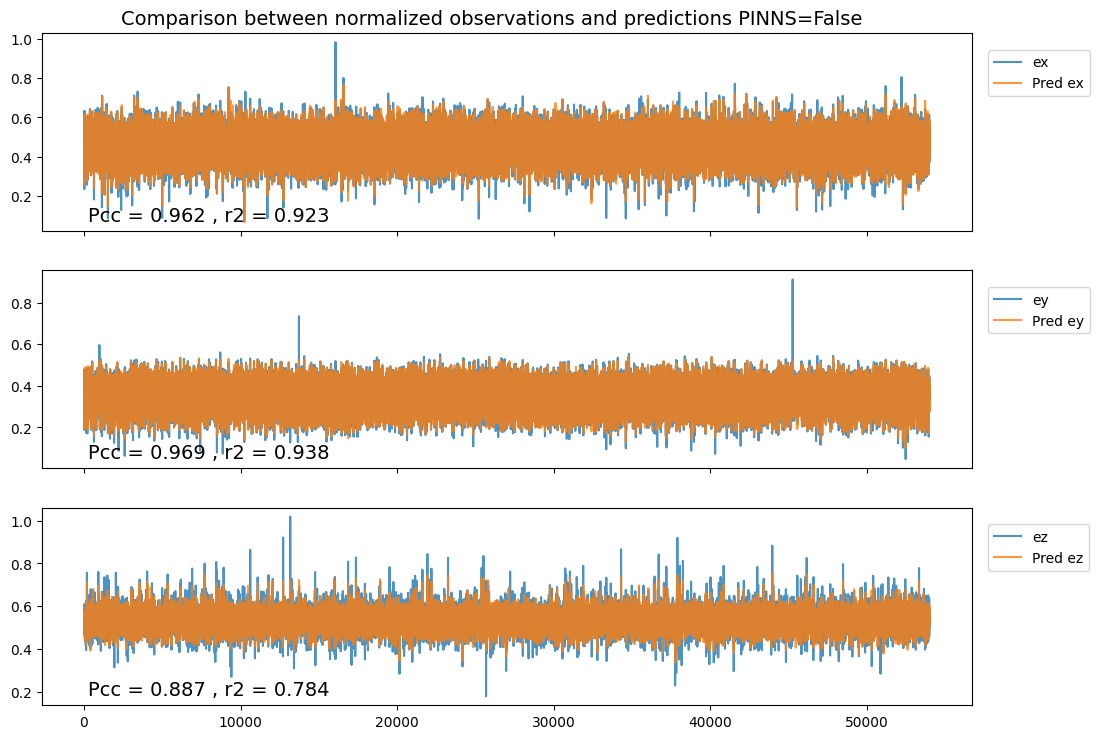

In [117]:
fig, ax = plt.subplots(len(output_targets), 1, figsize=(12,8),facecolor='white')
plt.subplots_adjust(hspace=0.2)
#plt.style.use('ggplot')

target_labels = output_targets

for i in range(y_test.shape[1]):
    ax[i].plot(y_test[:,i], label=target_labels[i],alpha=0.8)
    ax[i].plot(test_predict[:,i], label='Pred {}'.format(target_labels[i]),alpha=0.8)
    #ax[i].plot(d_theo_scale[test_ind_begin:test_ind_end,i], label='Theo {}'.format(target_labels[i]),alpha=0.8)
    #ax[i].plot(d_mhd_scale[test_ind_begin:test_ind_end,i], label='MHD {}'.format(target_labels[i]),alpha=0.8)
    #ax[i].plot(d_hall_scale[test_ind_begin:test_ind_end,i], label='Hall {}'.format(target_labels[i]),alpha=0.8)
    ax[i].legend(loc='upper left',bbox_to_anchor=(1.01, 0.95))
    text = str('Pcc = {}'.format(Pcc_xyz_test[i])) + str(' , r2 = {}'.format(r2_xyz_test[i]))
    ax[i].text(0.05, 0.05, text, fontsize=14, transform=ax[i].transAxes)
    
for i in range(y_test.shape[1]-1):
    plt.setp(ax[i].get_xticklabels(), visible=False)

fig = plt.gcf()
fig.subplots_adjust(top=0.95)
fig.suptitle(f"Comparison between normalized observations and predictions PINNS={PINNS}", fontsize=14)

plt.show()

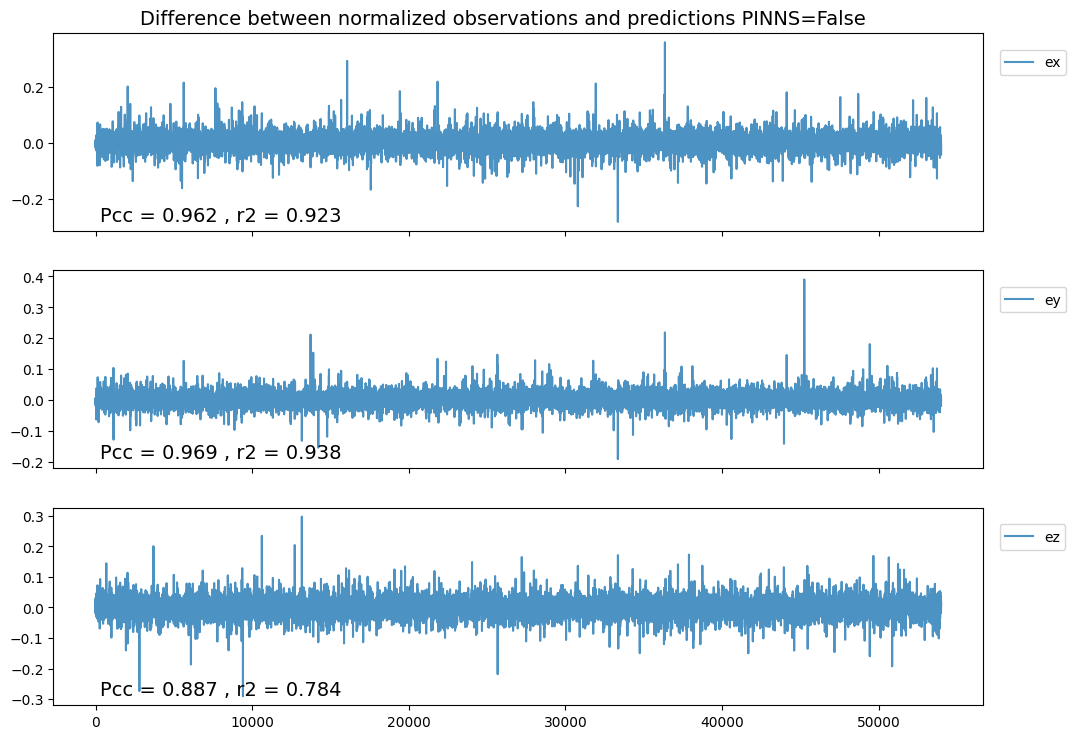

In [118]:
fig, ax = plt.subplots(len(output_targets), 1, figsize=(12,8),facecolor='white')
plt.subplots_adjust(hspace=0.2)
#plt.style.use('ggplot')

target_labels = output_targets

for i in range(y_test.shape[1]):
    ax[i].plot(y_test[:,i]-test_predict[:,i], label=target_labels[i],alpha=0.8)
    #ax[i].plot(d_theo_scale[test_ind_begin:test_ind_end,i], label='Theo {}'.format(target_labels[i]),alpha=0.8)
    #ax[i].plot(d_mhd_scale[test_ind_begin:test_ind_end,i], label='MHD {}'.format(target_labels[i]),alpha=0.8)
    #ax[i].plot(d_hall_scale[test_ind_begin:test_ind_end,i], label='Hall {}'.format(target_labels[i]),alpha=0.8)
    ax[i].legend(loc='upper left',bbox_to_anchor=(1.01, 0.95))
    text = str('Pcc = {}'.format(Pcc_xyz_test[i])) + str(' , r2 = {}'.format(r2_xyz_test[i]))
    ax[i].text(0.05, 0.05, text, fontsize=14, transform=ax[i].transAxes)
    
for i in range(y_test.shape[1]-1):
    plt.setp(ax[i].get_xticklabels(), visible=False)

fig = plt.gcf()
fig.subplots_adjust(top=0.95)
fig.suptitle(f"Difference between normalized observations and predictions PINNS={PINNS}", fontsize=14)

plt.show()

In [119]:
# test
predict_scaled = np.concatenate((X_test[:,:],test_predict), axis=1)
print(predict_scaled.shape)
print(predict_scaled)

(53992, 13)
[[0.74321457 0.35029034 0.58879795 ... 0.47786513 0.37236524 0.54137158]
 [0.60019601 0.41536979 0.67248218 ... 0.46584889 0.35863197 0.52598983]
 [0.5911036  0.44138185 0.56224623 ... 0.4556185  0.34547272 0.55490524]
 ...
 [0.64032693 0.266718   0.59654767 ... 0.44795904 0.36197612 0.52623677]
 [0.64823711 0.33406525 0.78156315 ... 0.41886091 0.33524945 0.52626729]
 [0.57347516 0.43242559 0.67892432 ... 0.42880517 0.33302653 0.53401548]]


In [120]:
# test 
predict = scaler.inverse_transform(predict_scaled)
print(predict)
print(predict.shape)

[[ 29.14144165  -9.3874574   19.27600298 ...  -0.62470272   0.12635835
    1.57427219]
 [  6.18420639   2.52251599  39.27382479 ...  -1.73292438  -1.33481
    0.41310728]
 [  4.7247009    7.28289524  12.9309992  ...  -2.67644293  -2.73490451
    2.59592435]
 ...
 [ 12.62599378 -24.68175406  21.12793551 ...  -3.38285254  -0.97900511
    0.43174887]
 [ 13.89572982 -12.35675706  65.34064845 ...  -6.06648562  -3.82262216
    0.43405264]
 [  1.89499632   5.64384098  40.81328793 ...  -5.14935618  -4.05913312
    1.0189614 ]]
(53992, 13)


In [124]:
# test 
df_predict = pd.DataFrame(predict)
df_predict.columns = df0.columns
df_predict['time'] = df_test.index
df_predict = df_predict.set_index(['time'])
df_predict

,bx,by,bz,jx,jy,jz,ux,uy,uz,e_density,ex,ey,ez
time,,,,,,,,,,,,,
2015-09-23 17:08:53.787,29.141442,-9.387457,19.276003,-8.737612e-08,4.792930e-08,-5.080751e-08,-188.258482,128.232346,-136.207316,4.275731,-0.624703,0.126358,1.574272
2015-09-25 15:48:23.368,6.184206,2.522516,39.273825,-1.753370e-08,1.792421e-10,-5.236555e-08,-47.932056,55.769751,-21.700135,1.152325,-1.732924,-1.334810,0.413107
2015-09-09 15:44:08.153,4.724701,7.282895,12.930999,-3.467727e-08,3.006261e-08,7.658823e-08,-256.693291,117.605746,-106.882480,11.584684,-2.676443,-2.734905,2.595924
2015-09-08 17:59:36.467,11.604480,5.903180,41.877210,8.989721e-10,5.385649e-08,-6.937610e-08,-70.993686,102.845435,-20.730152,3.374292,-3.237884,-2.715553,1.097033
2015-09-08 11:16:40.525,12.167840,12.378929,70.630498,-1.014956e-07,-3.297863e-08,-2.839097e-07,-191.600986,255.615691,8.041103,11.918461,-16.504529,-12.886729,3.914150
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2015-09-25 09:08:33.567,8.637296,0.193480,-37.924399,-1.630003e-07,1.120619e-07,2.776134e-07,-99.183503,133.549123,8.278172,16.018254,3.276562,3.372198,0.733943
2015-09-14 14:48:19.881,-25.990899,22.306646,-5.121162,3.298110e-09,1.139127e-08,-2.420158e-08,-173.339364,124.509180,-90.132167,13.920556,-1.278150,-1.189036,0.624838
2015-09-25 07:33:51.382,12.625994,-24.681754,21.127936,1.122677e-08,3.651880e-07,-5.050228e-09,-26.683352,230.118087,13.419645,40.157525,-3.382853,-0.979005,0.431749


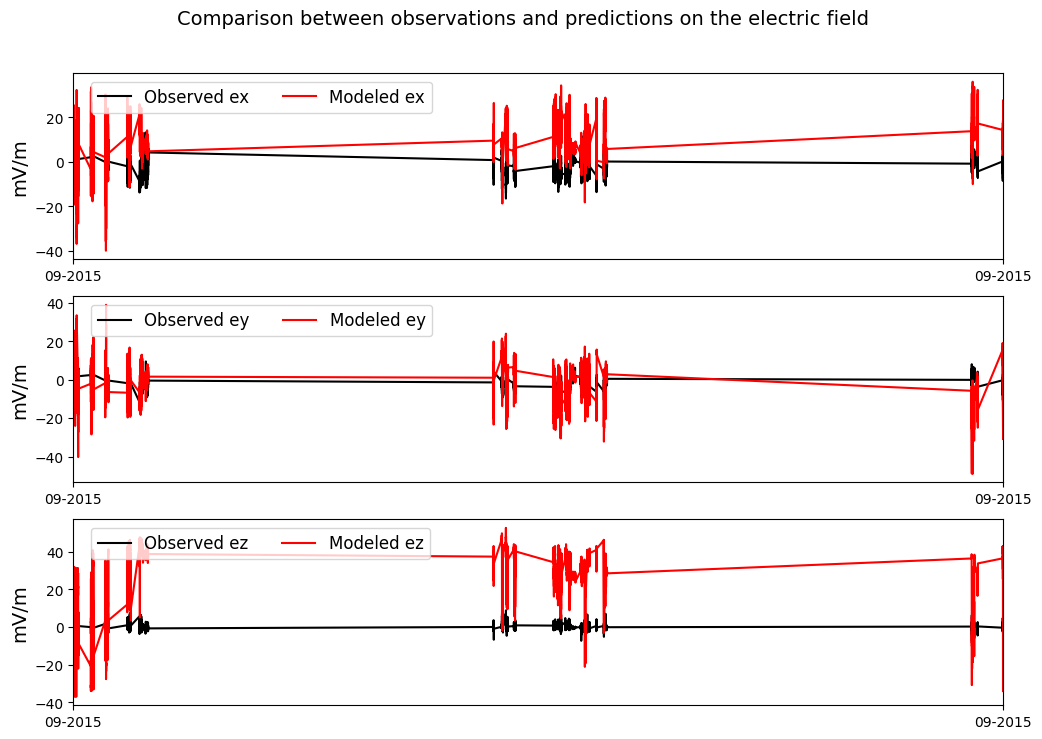

In [ ]:
## test 1

output_targets = ['ex','ey','ez']

fig, ax = plt.subplots(len(output_targets), 1, figsize=(12,8))
plt.subplots_adjust(hspace=0.2)

for j,col in enumerate(output_targets):
        ax[j].plot(df_test[col], label='Observed ' + col, color='k')
        ax[j].plot(df_predict[col], label='Modeled ' + col, color='r')
        #ax[j].plot(d_mhd[col+'_mhd'], label='MHD ' + col, color='g')
        #ax[j].plot(d_hall[col+'_hall'], label='Hall ' + col, color='b')
        ax[j].legend(loc='upper left',bbox_to_anchor=(.01, 1.0),ncols=2, fontsize=12)
        ax[j].set_xlim(t_test_begin, t_test_end)
        ax[j].xaxis.set_major_locator(mdates.MonthLocator(interval=2))
        ax[j].xaxis.set_minor_locator(mdates.DayLocator(interval=7))
        ax[j].xaxis.set_major_formatter(mdates.DateFormatter('%m-%Y'))
        ax[j].set_ylabel('mV/m', fontsize=14)
        ax[j].xaxis.get_label().set_fontsize(16)
        #text = str('Pcc = {}'.format(Pcc_xyz[j])) + str(' , r$^2$ = {}'.format(r2_xyz[j]))
        #ax[j].text(0.75, 0.05, text, fontsize=14, transform=ax[j].transAxes)

#ax[0].set_ylim(df_predict[t_test_begin:t_test_end][output_targets[0]].min() - 20, df_predict[t_test_begin:t_test_end][output_targets[0]].max() + 10)
#ax[1].set_ylim(df_predict[t_test_begin:t_test_end][output_targets[1]].min() - 20, df_predict[t_test_begin:t_test_end][output_targets[1]].max() + 10)
#ax[2].set_ylim(df_predict[t_test_begin:t_test_end][output_targets[2]].min() - 20, df_predict[t_test_begin:t_test_end][output_targets[2]].max() + 10)
    
fig = plt.gcf()
fig.subplots_adjust(top=0.9)
fig.suptitle("Comparison between observations and predictions on the electric field", fontsize=14)

plt.show()

/tmp/ipykernel_2477317/3702121706.py:9: RuntimeWarning: '<' not supported between instances of 'int' and 'Timestamp', sort order is undefined for incomparable objects.
  ax[j].plot(df_test[col]-df_predict[col], label='Diff ' + col, color='k')
/tmp/ipykernel_2477317/3702121706.py:9: RuntimeWarning: '<' not supported between instances of 'int' and 'Timestamp', sort order is undefined for incomparable objects.
  ax[j].plot(df_test[col]-df_predict[col], label='Diff ' + col, color='k')
/tmp/ipykernel_2477317/3702121706.py:9: RuntimeWarning: '<' not supported between instances of 'int' and 'Timestamp', sort order is undefined for incomparable objects.
  ax[j].plot(df_test[col]-df_predict[col], label='Diff ' + col, color='k')


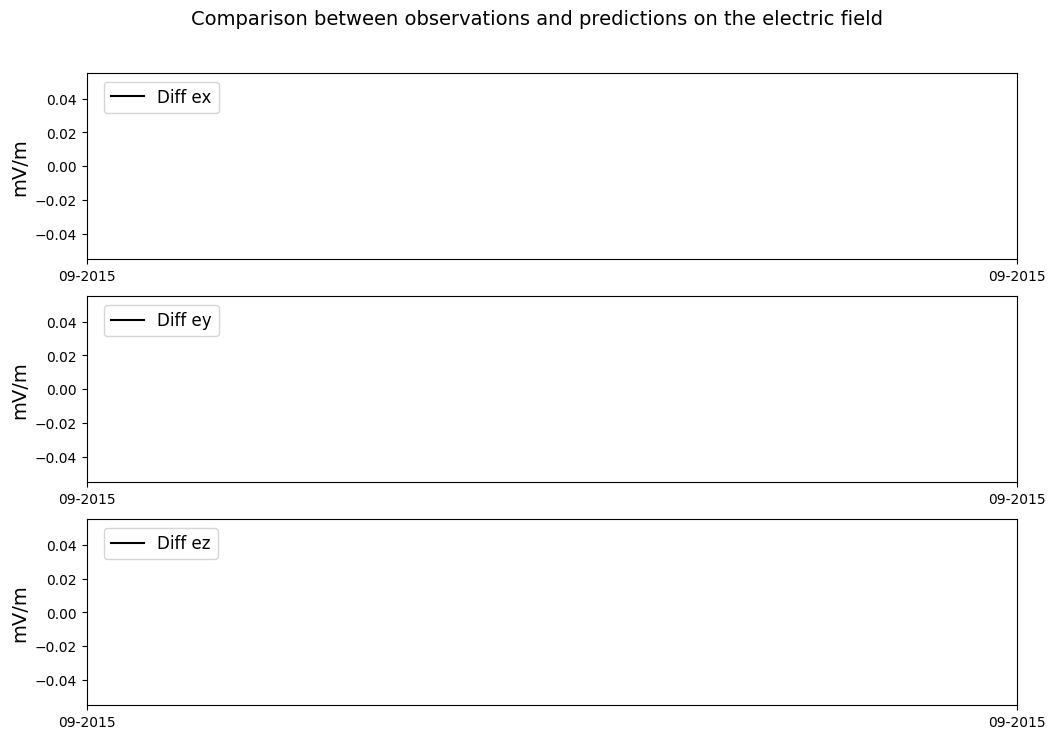

In [122]:
## test 1

output_targets = ['ex','ey','ez']

fig, ax = plt.subplots(len(output_targets), 1, figsize=(12,8))
plt.subplots_adjust(hspace=0.2)

for j,col in enumerate(output_targets):
        ax[j].plot(df_test[col]-df_predict[col], label='Diff ' + col, color='k')
        #ax[j].plot(d_mhd[col+'_mhd'], label='MHD ' + col, color='g')
        #ax[j].plot(d_hall[col+'_hall'], label='Hall ' + col, color='b')
        ax[j].legend(loc='upper left',bbox_to_anchor=(.01, 1.0),ncols=2, fontsize=12)
        ax[j].set_xlim(t_test_begin, t_test_end)
        ax[j].xaxis.set_major_locator(mdates.MonthLocator(interval=2))
        ax[j].xaxis.set_minor_locator(mdates.DayLocator(interval=7))
        ax[j].xaxis.set_major_formatter(mdates.DateFormatter('%m-%Y'))
        ax[j].set_ylabel('mV/m', fontsize=14)
        ax[j].xaxis.get_label().set_fontsize(16)
        #text = str('Pcc = {}'.format(Pcc_xyz[j])) + str(' , r$^2$ = {}'.format(r2_xyz[j]))
        #ax[j].text(0.75, 0.05, text, fontsize=14, transform=ax[j].transAxes)

#ax[0].set_ylim(df_predict[t_test_begin:t_test_end][output_targets[0]].min() - 20, df_predict[t_test_begin:t_test_end][output_targets[0]].max() + 10)
#ax[1].set_ylim(df_predict[t_test_begin:t_test_end][output_targets[1]].min() - 20, df_predict[t_test_begin:t_test_end][output_targets[1]].max() + 10)
#ax[2].set_ylim(df_predict[t_test_begin:t_test_end][output_targets[2]].min() - 20, df_predict[t_test_begin:t_test_end][output_targets[2]].max() + 10)
    
fig = plt.gcf()
fig.subplots_adjust(top=0.9)
fig.suptitle("Comparison between observations and predictions on the electric field", fontsize=14)

plt.show()

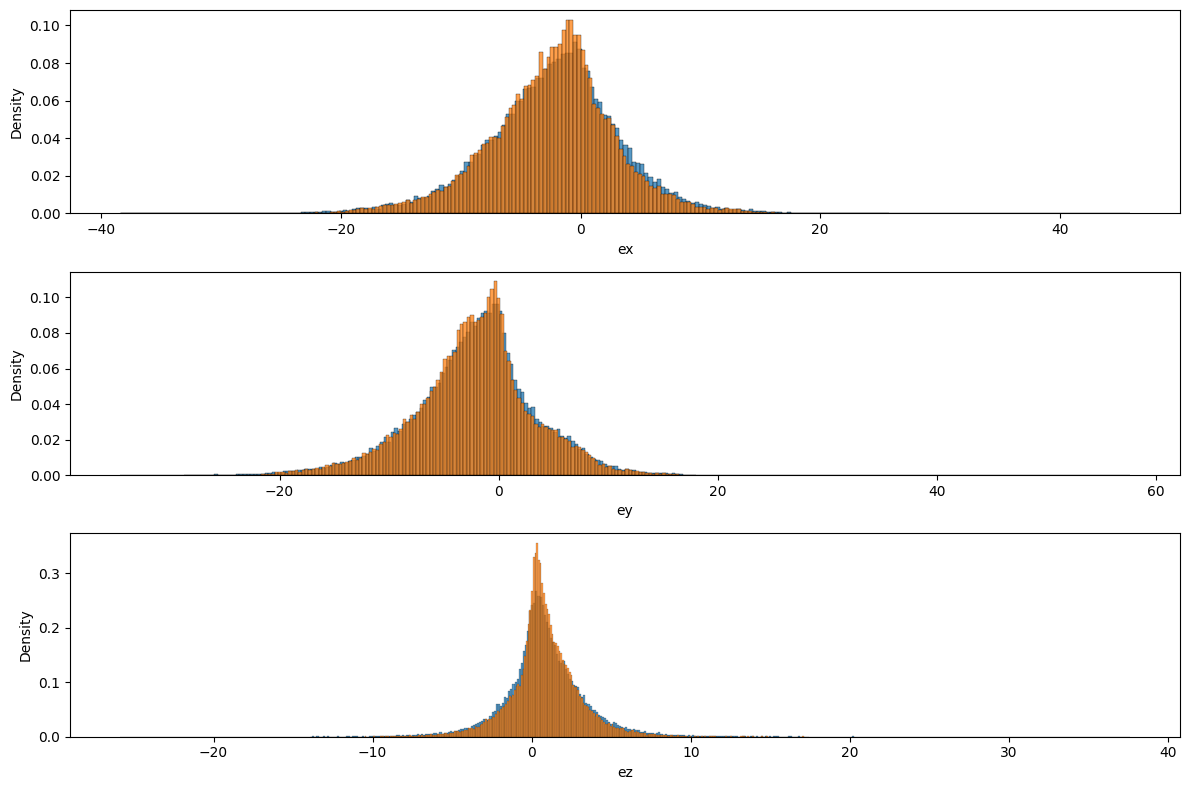

In [123]:
## test 1

output_targets = ['ex','ey','ez']

fig, ax = plt.subplots(len(output_targets), 1, figsize=(12,8))
plt.subplots_adjust(hspace=0.2)

for j,col in enumerate(output_targets):
        sns.histplot(df_test[col],ax=ax[j],stat='density')
        sns.histplot(df_predict[col],ax=ax[j],stat='density')

plt.tight_layout()
plt.show()